# We will test the Time-shift 1000
- We will use the vanilla model-Baseline (No augmentation)
- We will use the 1000ms augmentation model here

In [1]:
import numpy as np
import scipy.io

from keras import optimizers
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint


import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten, Activation
from keras.layers.core import Permute, Reshape
from keras import backend as K

from matplotlib import pyplot as plt
from PIL import Image as img_PIL


# random seed.
rand_seed = 2

from numpy.random import seed
seed(rand_seed)
from tqdm.keras import TqdmCallback
import tensorflow
tensorflow.random.set_seed(rand_seed)

## 1. Loading the data

In [2]:
def one_hot_encoding(y_data):
    Mapping=dict()
    sub_dirs=['downstair','upstair','run','jump','walk','handwashing','exercise']

    categories=7

    count=0
    for i in sub_dirs:
        Mapping[i]=count
        count=count+1

    y_features2=[]
    for i in range(len(y_data)):
        Type=y_data[i]
        lab=Mapping[Type]
        y_features2.append(lab)

    y_features=np.array(y_features2)
    y_features=y_features.reshape(y_features.shape[0],1)
    from keras.utils import to_categorical
    y_features = to_categorical(y_features)

    return y_features

In [3]:
path='C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/data/'

def get_train_and_validate_data(path=path):
    Train_data = np.load(path+'Data_train_all.npz')
    Train_data=np.load(path+'train_5000.npz')
    Features_imu=np.asarray(Train_data['arr_0'],dtype=np.float64)
    Labels=Train_data['arr_1']
    Features_audio=Train_data['arr_2']

    Labels = one_hot_encoding(Labels)
    
    randomize = np.arange(len(Labels))
    np.random.shuffle(randomize)
    
    Labels = Labels[randomize]
    Features_audio = Features_audio[randomize]
    Features_imu = Features_imu[randomize]
    
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 

    new_Labels = np.split(Labels,[Labels.shape[0] - 2000])
    new_Features_audio = np.split(Features_audio,[Features_audio.shape[0] - 2000])
    Features_imu = np.split(Features_imu,[Features_imu.shape[0] - 2000])
    
    return new_Labels[0],new_Features_audio[0],Features_imu[0],new_Labels[1],new_Features_audio[1],Features_imu[1]


def get_test_data(path=path):
    Train_data = np.load(path+'Data_test_71.pkl',allow_pickle=True)
    Labels = Train_data[1]
    Features_audio = Train_data[2]
    Features_imu = np.asarray(Train_data[0],dtype=np.float64)

    Labels = one_hot_encoding(Labels)
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 
    
    return Labels,Features_audio,Features_imu

In [4]:
Labels,Features_audio,Features_imu,Labels2,Features_audio2,Features_imu2 = get_train_and_validate_data()
print(Labels.shape,Features_audio.shape,Features_imu.shape)
print('Train Classes distribution: ',np.sum(Labels, axis = 0))

print(Labels2.shape,Features_audio2.shape,Features_imu2.shape)
print('Validate Classes distribution: ',np.sum(Labels2, axis = 0))

Labels3,Features_audio3,Features_imu3 = get_test_data()
print(Labels3.shape,Features_audio3.shape,Features_imu3.shape)
print('Test Classes distribution: ',np.sum(Labels3, axis = 0))

(3000, 7) (3000, 193) (3000, 1, 40, 12)
Train Classes distribution:  [440. 626. 324. 458. 326. 434. 392.]
(2000, 7) (2000, 193) (2000, 1, 40, 12)
Validate Classes distribution:  [320. 368. 222. 322. 206. 298. 264.]
(1377, 7) (1377, 193) (1377, 1, 40, 12)
Test Classes distribution:  [219. 268. 124. 146. 143. 234. 243.]


In [5]:
model_path = 'C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models/imu_audio_combined_model_shift_checkpoint'

from keras.models import load_model

model = load_model(model_path)

In [6]:
## Test Accuracy
model.evaluate([Features_audio3,Features_imu3],Labels3)

44/44 [==============================] - 0s 2ms/step - loss: 0.2865 - accuracy: 0.9288


[0.2864573001861572, 0.9288308024406433]

## Observation: All of these test labels are continuous.
### Time window used to create a sample: 2 Second.

# Time shifting, our goal is to randomly insert the samples of different continuous windows in between which is to simulate the real-time deployment setting

# First preprocess the data to get the continuous acc and gyro windows
- data ordering: 12 sensors each with 40 samples.
- 12 sensors are: acc_right, gyro_right, acc_left, gyro_left

In [7]:
def get_test_data2(path=path):
    Train_data=np.load(path+'Data_test_71.pkl',allow_pickle=True)
    Features_imu=np.asarray(Train_data[0],dtype=np.float64)
    Labels=Train_data[1]
    Features_sound=Train_data[2]
    
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 

    return Features_imu,Labels,Features_sound

In [8]:
Features_imu_t1,Labels_t1,Features_sound_t1 = get_test_data2()
#print(Features_imu_t1.shape, Labels_t1.shape, Features_sound_t1.shape)

In [9]:
# We see all of the labels are continuous
Labels_t1 = np.array(Labels_t1)

In [10]:
Labels_t1[:100]

array(['downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'down

# Getting windows of data together with num_windows_together in each

In [11]:
# For 10 second together
num_windows_together = 5

curr_indx = 0
final_indx = Features_imu_t1.shape[0]

data_together = []

while curr_indx <= final_indx:
    IMU_together   = Features_imu_t1[curr_indx:curr_indx+num_windows_together]
    sound_together = Features_sound_t1[curr_indx:curr_indx+num_windows_together]
    labels_together = Labels_t1[curr_indx:curr_indx+num_windows_together]
    
    data_together.append([IMU_together,sound_together,labels_together])
    
    curr_indx = curr_indx+num_windows_together
    

# Now we randomly distribute the windows

In [12]:
rand_seed = 4
from numpy.random import seed
seed(rand_seed)

ordering = np.arange(len(data_together))
np.random.shuffle(ordering)

In [13]:
ordering[:100]

array([166, 225, 146, 215,  82,  46,  18, 113, 253,  47, 171, 275,   6,
       123, 250, 232, 203, 124,  45, 133, 111,  24,   1, 159, 212, 101,
       137, 128, 139, 256,  33,  11, 106,  68,  39,  69, 110,  43,  83,
       108, 169,  64, 223, 189, 134,  88, 235,  93, 191, 260, 249, 271,
       254, 100,  92,  71, 103,  63, 267, 144,  13,  42,  14, 268, 182,
       140,  84,  48, 130,  55, 184, 152, 251, 178,  20, 175, 129, 266,
       269, 218, 227, 193, 261,  91, 216, 162, 229, 116, 121,  34, 233,
       112, 247, 231, 239, 153,  57,  81,  70,  26])

## Now we again recreate the test data

In [14]:
indx = ordering[0]

Features_imu_t1  = data_together[indx][0]
Features_sound_t1 = data_together[indx][1]
Labels_t1 = data_together[indx][2]


#print(Features_imu_t1.shape,Labels_t1.shape,Features_sound_t1.shape)

for i in range(1, len(data_together)):
    indx = ordering[i]
    IMU_together  = data_together[indx][0]
    sound_together= data_together[indx][1]
    labels_together=data_together[indx][2]
    #print(indx, IMU_together.shape,sound_together.shape,labels_together.shape)
    Features_imu_t1 = np.concatenate((Features_imu_t1,IMU_together),axis=0)
    Labels_t1 = np.concatenate((Labels_t1,labels_together),axis=0)
    Features_sound_t1 = np.concatenate((Features_sound_t1,sound_together),axis=0)
    #print(indx, IMU_together.shape,sound_together.shape,labels_together.shape)

In [15]:
print(Features_imu_t1.shape, Labels_t1.shape, Features_sound_t1.shape)

(1377, 1, 40, 12) (1377,) (1377, 193)


In [16]:
Labels_t1[:100]

array(['walk', 'walk', 'walk', 'walk', 'walk', 'handwashing',
       'handwashing', 'handwashing', 'handwashing', 'handwashing', 'jump',
       'jump', 'jump', 'jump', 'jump', 'handwashing', 'handwashing',
       'handwashing', 'handwashing', 'handwashing', 'upstair', 'upstair',
       'upstair', 'upstair', 'upstair', 'upstair', 'upstair', 'upstair',
       'upstair', 'upstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'run', 'run', 'run', 'run', 'run',
       'exercise', 'exercise', 'exercise', 'exercise', 'exercise',
       'upstair', 'upstair', 'upstair', 'upstair', 'upstair', 'walk',
       'walk', 'walk', 'walk', 'walk', 'exercise', 'exercise',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'jump', 'jump', 'jump', 'jump', 'jump', 'exercise', 'exercise',
       'exercise', 'exercise', 'exercise', 'exercise', 'exercise',
       'exercise', 'exercise', 'exercise', 'handwashing', 'handwashing',
       'handwashing', 'handw

In [17]:
Labels_t1 = one_hot_encoding(Labels_t1)

# Testing accuracy on Reshuffled data.
## Note: not time errors are introduced so Accuracy should be same as the fusion model on original continuous test data

In [18]:
model.evaluate([Features_sound_t1,Features_imu_t1],Labels_t1)

44/44 [==============================] - 0s 2ms/step - loss: 0.2865 - accuracy: 0.9288


[0.286457359790802, 0.9288308024406433]

# Now aggregating the data and doing the timing errors

In [19]:
acc_right=[]
gyro_right=[]
acc_left=[]
gyro_left=[]

for i in range(Features_imu_t1.shape[0]):
    acc_right.append([Features_imu_t1[i,0,:,0],Features_imu_t1[i,0,:,1],Features_imu_t1[i,0,:,2]])
    gyro_right.append([Features_imu_t1[i,0,:,3],Features_imu_t1[i,0,:,4],Features_imu_t1[i,0,:,5]])
    acc_left.append([Features_imu_t1[i,0,:,6],Features_imu_t1[i,0,:,7],Features_imu_t1[i,0,:,8]])
    gyro_left.append([Features_imu_t1[i,0,:,9],Features_imu_t1[i,0,:,10],Features_imu_t1[i,0,:,11]])
        

In [20]:
acc_right=np.array(acc_right)
gyro_right=np.array(gyro_right)
acc_left=np.array(acc_left)
gyro_left=np.array(gyro_left)

In [21]:
print(acc_right.shape)
print(gyro_right.shape)
print(acc_left.shape)
print(gyro_left.shape)

(1377, 3, 40)
(1377, 3, 40)
(1377, 3, 40)
(1377, 3, 40)


In [22]:
acc_right_cont= acc_right[0,]
gyro_right_cont= gyro_right[0,]

acc_left_cont= acc_left[0,]
gyro_left_cont= gyro_left[0,]


for i in range(1, Features_imu_t1.shape[0]):
    #print(i)
    acc_right_cont=np.hstack((acc_right_cont,acc_right[i,]))
    gyro_right_cont=np.hstack((gyro_right_cont,gyro_right[i,]))
    acc_left_cont=np.hstack((acc_left_cont,acc_left[i,]))
    gyro_left_cont=np.hstack((gyro_left_cont,gyro_left[i,]))

In [23]:
print(acc_right_cont.shape)
print(gyro_right_cont.shape)
print(acc_left_cont.shape)
print(gyro_left_cont.shape)


(3, 55080)
(3, 55080)
(3, 55080)
(3, 55080)


# Now shifting the samples

# Defining function to do the evaluation

In [24]:
def get_data_sample_shift(shift_samples = 1):
    sample_size = 40 #need to be 40, as decided during training
    total_samples = acc_right_cont.shape[1]
    
    #print(total_samples)
    
    current_cursor = shift_samples

    i = 0

    acc_right_pro= np.array(acc_right_cont[np.newaxis,:,current_cursor:current_cursor+sample_size])

    #print(acc_right_pro.shape)

    gyro_right_pro= np.array(gyro_right_cont[np.newaxis,:,current_cursor:current_cursor+sample_size])

    acc_left_pro= np.array(acc_left_cont[np.newaxis,:,current_cursor:current_cursor+sample_size])

    gyro_left_pro= np.array(gyro_left_cont[np.newaxis,:,current_cursor:current_cursor+sample_size])

    #print(np.array(acc_right_cont[np.newaxis,:,current_cursor:current_cursor+sample_size]).shape)

    while current_cursor<=(total_samples-2*sample_size):
        current_cursor = current_cursor + sample_size
        #print(current_cursor," : ", i)
        a=acc_right_pro
        b=np.array(acc_right_cont[np.newaxis,:,current_cursor:current_cursor+sample_size])
        acc_right_pro = np.concatenate((a,b),axis=0)


        a=gyro_right_pro
        b=np.array(gyro_right_cont[np.newaxis,:,current_cursor:current_cursor+sample_size])
        gyro_right_pro = np.concatenate((a,b),axis=0)


        a=acc_left_pro
        b=np.array(acc_left_cont[np.newaxis,:,current_cursor:current_cursor+sample_size])
        #print(a.shape,b.shape)
        acc_left_pro = np.concatenate((a,b),axis=0)

        a=gyro_left_pro
        b=np.array(gyro_left_cont[np.newaxis,:,current_cursor:current_cursor+sample_size])
        gyro_left_pro = np.concatenate((a,b),axis=0)
        i = i+1
        
    IMU_processed = np.concatenate((acc_right_pro,gyro_right_pro,acc_left_pro,gyro_left_pro),axis=1)
    IMU_processed = IMU_processed[:,np.newaxis,:,:]
    IMU_processed = np.swapaxes(IMU_processed,2,3)
        
    size = IMU_processed.shape[0]
        
    return Features_sound_t1[:size], IMU_processed ,Labels_t1[:size]
        


In [25]:
Accuracy_vanilla = []
Accuracy_1000ms = []

In [26]:
model_path1 = 'C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models/imu_audio_combined_model_checkpoint'
model_path2 = 'C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models/imu_audio_combined_model_shift_checkpoint'

from keras.models import load_model
model1 = load_model(model_path1)
model2 = load_model(model_path2)

In [27]:
def get_shifted_data(file,path=path):
    Train_data = np.load(path+file)
    Labels = Train_data['arr_1']
    Features_imu = np.asarray(Train_data['arr_0'],dtype=np.float64)
    Features_audio = Train_data['arr_2']
    
    return Labels,Features_imu,Features_audio

In [28]:
for shift in range(41):
    Features_sound, IMU ,Labels =  get_data_sample_shift(shift_samples = shift)
    evaluation1 = model1.evaluate([Features_sound,IMU],Labels)
    Accuracy_vanilla.append(evaluation1[1])
    
    evaluation2 = model2.evaluate([Features_sound,IMU],Labels)
    Accuracy_1000ms.append(evaluation2[1])
    
    print("Shift is:",shift,evaluation1[1],evaluation2[1])

#for i in range(1,40):
#    shift_path='E:/augmented_data/'
#    file='test_data_'+str(i)+'_shift.npz'

#    shiftLabels,shiftFeatures_imu,shiftFeatures_audio = get_shifted_data(file,shift_path)

#    evaluation1 = model.evaluate([shiftFeatures_audio,shiftFeatures_imu],shiftLabels)
#    Accuracy_vanilla.append(evaluation1[1])
    
#    evaluation2 = model2.evaluate([shiftFeatures_audio,shiftFeatures_imu],shiftLabels)
#    Accuracy_1000ms.append(evaluation2[1])

44/44 [==============================] - 0s 2ms/step - loss: 0.2865 - accuracy: 0.9288
Shift is: 0 0.9440813064575195 0.9288308024406433
43/43 [==============================] - 0s 2ms/step - loss: 0.3042 - accuracy: 0.9244
Shift is: 1 0.944767415523529 0.9244186282157898
43/43 [==============================] - 0s 2ms/step - loss: 0.3449 - accuracy: 0.9201
Shift is: 2 0.9331395626068115 0.9200581312179565
43/43 [==============================] - 0s 2ms/step - loss: 0.3669 - accuracy: 0.9172
Shift is: 3 0.930232584476471 0.917151153087616
43/43 [==============================] - 0s 2ms/step - loss: 0.3709 - accuracy: 0.9193
Shift is: 4 0.9280523061752319 0.9193313717842102
43/43 [==============================] - 0s 2ms/step - loss: 0.4506 - accuracy: 0.9106
Shift is: 5 0.9186046719551086 0.9106104373931885
43/43 [==============================] - 0s 2ms/step - loss: 0.4614 - accuracy: 0.9150
Shift is: 6 0.9193313717842102 0.9149709343910217
43/43 [==============================] - 0s 

43/43 [==============================] - 0s 2ms/step - loss: 4.2651 - accuracy: 0.7783
Shift is: 36 0.8270348906517029 0.7783430218696594
43/43 [==============================] - 0s 2ms/step - loss: 4.6274 - accuracy: 0.7733
Shift is: 37 0.8226743936538696 0.7732558250427246
43/43 [==============================] - 0s 2ms/step - loss: 4.9270 - accuracy: 0.7689
Shift is: 38 0.8284883499145508 0.7688953280448914
43/43 [==============================] - 0s 2ms/step - loss: 5.0246 - accuracy: 0.7791
Shift is: 39 0.8277616500854492 0.7790697813034058
43/43 [==============================] - 0s 2ms/step - loss: 5.1190 - accuracy: 0.7842
Shift is: 40 0.832848846912384 0.7841569781303406


In [29]:
Accuracy_vanilla

[0.9440813064575195,
 0.944767415523529,
 0.9331395626068115,
 0.930232584476471,
 0.9280523061752319,
 0.9186046719551086,
 0.9193313717842102,
 0.9244186282157898,
 0.9193313717842102,
 0.917151153087616,
 0.9193313717842102,
 0.9156976938247681,
 0.9055232405662537,
 0.9055232405662537,
 0.9040697813034058,
 0.9004360437393188,
 0.8909883499145508,
 0.8909883499145508,
 0.8837209343910217,
 0.8888081312179565,
 0.8880813717842102,
 0.8837209343910217,
 0.8786337375640869,
 0.8706395626068115,
 0.8691860437393188,
 0.8524709343910217,
 0.8597383499145508,
 0.8561046719551086,
 0.854651153087616,
 0.8539243936538696,
 0.8481104373931885,
 0.8473837375640869,
 0.8473837375640869,
 0.8393895626068115,
 0.8357558250427246,
 0.8343023061752319,
 0.8270348906517029,
 0.8226743936538696,
 0.8284883499145508,
 0.8277616500854492,
 0.832848846912384]

In [30]:
Accuracy_1000ms

[0.9288308024406433,
 0.9244186282157898,
 0.9200581312179565,
 0.917151153087616,
 0.9193313717842102,
 0.9106104373931885,
 0.9149709343910217,
 0.9091569781303406,
 0.9069767594337463,
 0.9055232405662537,
 0.895348846912384,
 0.8873546719551086,
 0.8938953280448914,
 0.8873546719551086,
 0.8793604373931885,
 0.8742732405662537,
 0.8713662624359131,
 0.8619186282157898,
 0.8626453280448914,
 0.8633720874786377,
 0.8531976938247681,
 0.8459302186965942,
 0.8357558250427246,
 0.8357558250427246,
 0.819767415523529,
 0.8088662624359131,
 0.8081395626068115,
 0.7950581312179565,
 0.7950581312179565,
 0.7899709343910217,
 0.7776162624359131,
 0.78125,
 0.7827034592628479,
 0.7710756063461304,
 0.7732558250427246,
 0.7754360437393188,
 0.7783430218696594,
 0.7732558250427246,
 0.7688953280448914,
 0.7790697813034058,
 0.7841569781303406]

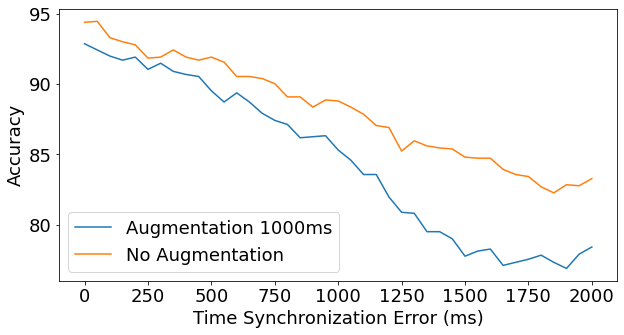

In [31]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 18})

y = np.arange(len(Accuracy_vanilla[:41]))

y = y * 50

plt.plot(y,(np.array(Accuracy_1000ms[:41])*100))
plt.plot(y,(np.array(Accuracy_vanilla[:41])*100))

#plt.title('Fused Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Time Synchronization Error (ms)')
plt.legend(['Augmentation 1000ms','No Augmentation'], loc='lower left')
plt.show()